In [2]:
import numpy as np
import matplotlib.pyplot as plt

from colors import C
from fenics import *
from mesh_utils import get_square_f, get_L_mesh
from matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W, tikhonov_solver

set_log_level(30)  # ignore info logging

/home/elias/miniforge3/envs/fenics_env/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [10]:
# Function space
n = 256
mesh = UnitSquareMesh(n, n)
V_h = FunctionSpace(mesh, 'CG', 1)

rsvd = MatrixFreeRSVD(V_h)
print(f"K shape : {rsvd.N_b, rsvd.N}")


K shape : (1024, 66049)


In [23]:
def progress_bar(step, total_steps, bar_length=30, fill='#', end_text=''):
    """
    Simple progress bar.
    """
    filled = int(bar_length * step / total_steps)
    text = f"[{filled * fill :<{bar_length}}] {step}/{total_steps}"
    end = '\r' if step < total_steps else '\n' 
    print(text + end_text, end=end)


def compute_times_across_k(rsvd, lower, upper, step):
    times = []
    k_range = np.arange(lower, upper, step)
    for i, k in enumerate(k_range):
        rsvd.mf_rsvd(k)
        times.append(rsvd.times)
        progress_bar(i + 1, len(k_range), end_text=f' (k={k}, N_b={rsvd.N_b})')

    times = np.array(times)
    times_tot = np.sum(times, axis=1)
    return times, times_tot, k_range


times, times_tot, k_range = compute_times_across_k(rsvd, 5, 300, 10)

[##############################] 30/30 (k=295, N_b=1024)


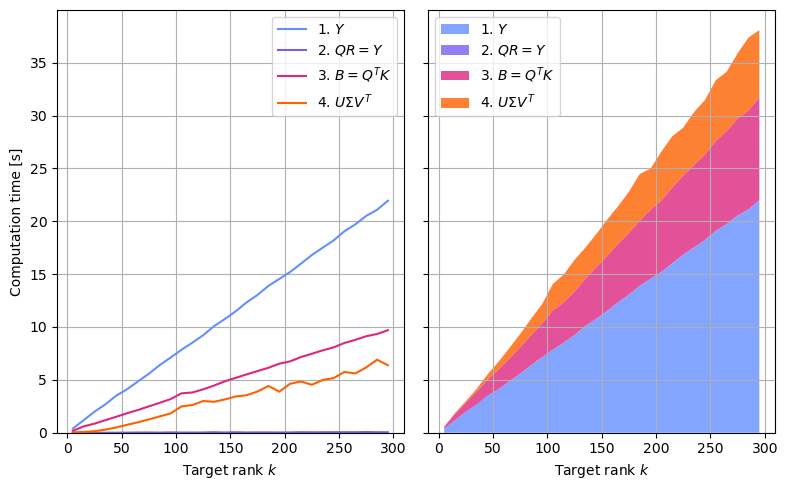

In [24]:
def plot_times_across_k(x_axis, times, times_tot, x_label='Target rank $k$'):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
    ax1, ax2 = axes

    ax1.plot(x_axis, times[:, 0], label='1. $Y$', c=C.c5[0])
    ax1.plot(x_axis, times[:, 1], label='2. $QR = Y$', c=C.c5[1])
    ax1.plot(x_axis, times[:, 2], label='3. $B = Q^T K$', c=C.c5[2])
    ax1.plot(x_axis, times[:, 3], label='4. $U \Sigma V^T$', c=C.c5[3])

    ax2.stackplot(
        x_axis,
        times[:, 0], times[:, 1], times[:, 2], times[:, 3],
        labels=['1. $Y$', '2. $QR = Y$', '3. $B = Q^T K$', '4. $U \Sigma V^T$'],
        alpha=0.8,
        colors=[C.c5[0], C.c5[1], C.c5[2], C.c5[3]]
    )

    ax1.set_xlabel(x_label)
    ax2.set_xlabel(x_label)
    ax1.set_ylabel("Computation time [s]")

    ax1.legend()
    ax2.legend()
    ax1.grid()
    ax2.grid()

    plt.tight_layout()
    plt.show()


plot_times_across_k(k_range, times, times_tot)

In [25]:
def compute_times_across_N(k, lower=32, upper=272, step=16):
    times = []
    n_range = np.arange(lower, upper, step)
    N_range = []
    N_b_range = []

    for i, n in enumerate(n_range):
        mesh = UnitSquareMesh(n, n)
        V_h = FunctionSpace(mesh, 'CG', 1)
        rsvd = MatrixFreeRSVD(V_h)
        N, N_b = rsvd.N, rsvd.N_b

        N_range.append(N)
        N_b_range.append(N_b)

        rsvd.mf_rsvd(k)
        times.append(rsvd.times)

        progress_bar(i + 1, len(n_range), end_text=f' (N_b={N_b}, N={N})')

    times = np.array(times)
    times_tot = np.sum(times, axis=1)
    return times, times_tot, N_b_range, N_range


times, times_tot, N_b_range, N_range = compute_times_across_N(
    k=25, lower=32, upper=1028, step=16
)

KeyboardInterrupt: 

UnboundLocalError: local variable 'times' referenced before assignment

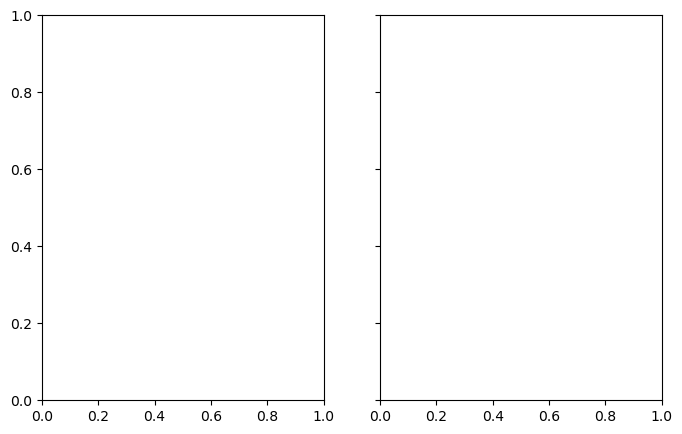

In [26]:
def plot_times_across_N(x_axis, x_label='Mesh nodes $N$'):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
    ax1, ax2 = axes
    
    times = times / times_tot
    ax1.plot(x_axis, times[:, 0], label='1. $Y$', c=C.c5[0])
    ax1.plot(x_axis, times[:, 1], label='2. $QR = Y$', c=C.c5[1])
    ax1.plot(x_axis, times[:, 2], label='3. $B = Q^T K$', c=C.c5[2])
    ax1.plot(x_axis, times[:, 3], label='4. $U \Sigma V^T$', c=C.c5[3])

    ax2.stackplot(
        x_axis,
        times[:, 0], times[:, 1], times[:, 2], times[:, 3],
        labels=['1. $Y$', '2. $QR = Y$', '3. $B = Q^T K$', '4. $U \Sigma V^T$'],
        alpha=0.8,
        colors=[C.c5[0], C.c5[1], C.c5[2], C.c5[3]]
    )

    ax1.set_xlabel(x_label)
    ax2.set_xlabel(x_label)
    ax1.set_ylabel("Computation time [s]")

    ax1.legend()
    ax2.legend()
    ax1.grid()
    ax2.grid()

    plt.tight_layout()
    plt.show()


plot_times_across_N(N_range)

In [3]:
rsvd = MatrixFreeRSVD(V_h)

f = get_square_f(V_h, 0.65, 0.65)
x = f.vector().get_local()
y = rsvd.apply_K(x)

ks = [5, 10, 50]

sols = [f]
for k in ks:
    # Perform matrix-free rSVD
    Uk, Sk, VkT = rsvd.mf_rsvd(k=k)
    w = get_approximate_W(Vk=VkT.T, M_dx=rsvd.M_dx)

    # Solve y = (K_k)(x)
    x_hat = tikhonov_solver(rsvd, W_diag=w, y=y, lambda_=1e-3)

    f_hat = Function(V_h)
    f_hat.vector()[:] = x_hat
    sols.append(f_hat)


4 4 4


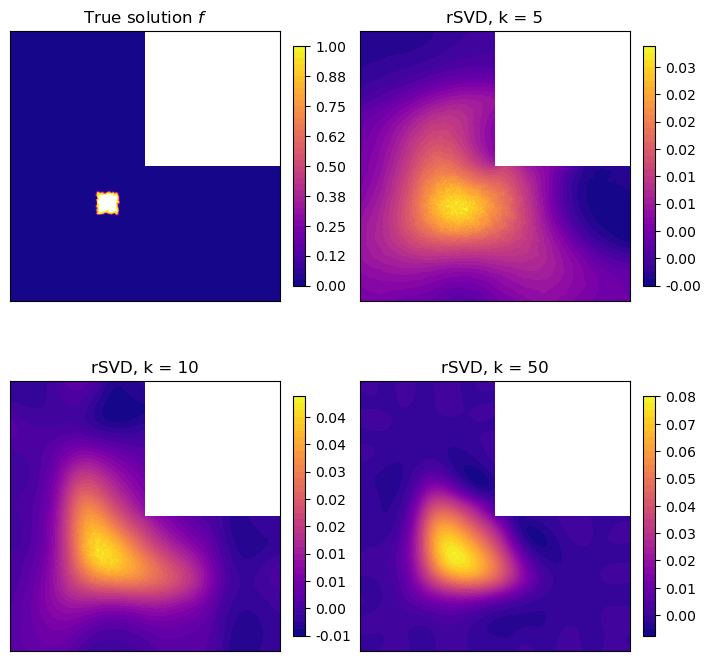

In [4]:
def plot_many_f(sols, ks):
    fig, axes = plt.subplots(2, 2, figsize=(7, 7), constrained_layout=True)
    axes = axes.flatten()

    names = [
        "True solution $f$",
        f"rSVD, k = {ks[0]}",
        f"rSVD, k = {ks[1]}",
        f"rSVD, k = {ks[2]}"
    ]
    print(len(axes), len(sols), len(names))
    for ax, func, name in zip(axes, sols, names):
        plt.sca(ax)
        p = plot(func, title=name, cmap='plasma')
        fig.colorbar(p, ax=ax, format="%.2f", shrink=0.7)
        ax.set_xticks([])
        ax.set_yticks([])


plot_many_f(sols, ks)